In [171]:
import pyMRAW
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy import integrate
import warnings
warnings.simplefilter("default")

# Funkcije

In [172]:
def load_video(cih_file):
    """Loading video from file
    Input:
        cih_file: CIH file of MRAW video
     """
    video = pyMRAW.load_video(cih_file)
    images = video[0]
    cih = video[1]
    return images, cih

In [173]:
def subset(images, r, c, subset_size=3):
    """Croping of video frames. 
    
    Returns images of subset through time(t, r, c)
    t - time
    r - rows
    c - columns
    
    Input: center of subset coordinates and subset size.
    """
    sub = subset_size//2+1
    subset_images = images[:, r-sub+1:r+sub, c-sub+1:c+sub]
    return subset_images

In [174]:
def displacement(images, reference='all', direction='r', pixel_size=1):
    """Displacement with reference to the first image.
    Input:
    -reference: determines reference images used as reference:
        - Default: 'all'
        - Possible input types: integer, array, list
    -pixel_size: size of pixel in physical units
    -direction: direction of displacement identification:
        - Default: 'both'
        - possible: 'r' - rows, 'c' - columns
    
    """
    if reference=='all':
        ref = np.average(images, axis=(0))
    elif type(reference) is int:
        ref = images[reference]
    elif type(reference) in [list, np.ndarray]:
        ref = np.average(images[reference,:,:], axis=(0))
    else:
        raise Exception('`reference` can be \'all\' or type: integer, np.array, list')

    gradient_r, gradient_c = np.gradient(ref)

    mid = np.shape(images)[1]//2
    grad_r = gradient_r[mid, mid] #gradient of central pixel
    grad_c = gradient_c[mid, mid]

    I = np.average(images, axis=(1,2)) #average intensity of given subset at each frame
    I0 = np.average(ref) #reference instensity

    def check_max(d):
        if np.max(d)/pixel_size>0.5:
            warnings.warn('Displacement larger than 0.5 pixel')
    
    if direction=='both':
        grad = np.sqrt(grad_r**2 + grad_c**2)
        disp_r = pixel_size * np.shape(images)[1]*(I-I0)/grad
        disp_c = pixel_size * np.shape(images)[1]*(I-I0)/grad
        check_max(disp_r)
        check_max(disp_c)
        return disp_r, disp_c, ref, grad_r, grad_c
    elif direction=='c':
        disp_c = pixel_size * np.shape(images)[1]*(I-I0)/grad_c
        check_max(disp_c)
        return disp_c, ref, grad_c
    elif direction=='r':
        disp_r = pixel_size * np.shape(images)[1]*(I-I0)/grad_r
        check_max(disp_r)
        return disp_r, ref, grad_r
    else:
        raise Exception('Direction can be: r, c, both')  

In [230]:
def get_points(images, area_r=None, area_c=None, reference='all', direction='both', mesh=False, mode='points',points=100, limit=10000):
    """ Get points with highest gradient.
    Input:
    -area_r: Rows over which gradient is calculated
    -area_c: Rows over which gradient is calculated
    -reference image: image on which gradient is calculated
    -direction: direction of gradient. Possible inputs: x,y,both. Default is both
    -mesh: if True, image is divided into mesh. Point with highest gradient is located in every cell. 
        If gradient of point is higher than 'limit', point is added to output.
        Density of mesh is set by: 'points'
    -mode: Posible inputs: limit, points, Default is points
        -mode='limit': Set a limit of gradient. Functions returns all points in which gradient is higher than limit.
        -mode='points': Set a number of points. Function returns given number of points with highest gradient.
    
    Output:
    -Number of points, 
    -array with coordinates of points
    """
    if area_r != None and area_c != None:
        images = images[:,area_r[0]:area_r[1],area_c[0]:area_c[1]]
    
    if reference=='all':
        ref = np.average(images, axis=(0))
    elif type(reference) is int:
        ref = images[reference]
    elif type(reference) in [list, np.ndarray]:
        ref = np.average(images[reference,:,:], axis=(0))
    else:
        raise Exception('`reference` can be \'all\' or type: integer, np.array, list')

    if direction=='both':
        gradient_r, gradient_c = np.abs(np.gradient(ref))
        
    elif direction=='r':
        gradient_r = gradient_c = np.abs(np.gradient(ref,axis=0))
        
    elif direction=='c':
        gradient_c = gradient_r = np.abs(np.gradient(ref,axis=1))
    
    if mode=='points':
        flatten_r = gradient_r.flatten()
        flatten_c = gradient_c.flatten()
        
        limit_r = sorted(flatten_r,reverse=True)[points]
        limit_c = sorted(flatten_c,reverse=True)[points]
    elif mode=='limit':
        limit_r = limit_c = limit
    else:
        raise Exception('Posible inputs for mode: limit, points')
        
        
    number_of_points_c = number_of_points_r = 0
    points_c = points_r = np.empty((0, 2),int)
    

    if mesh==False:
        for i in range(np.shape(gradient_r)[0]):
            for j in range(np.shape(gradient_r)[1]):
                if gradient_r[i,j]>limit_r:
                    number_of_points_r += 1
                    points_r = np.append(points_r, np.array([[i+area_r[0], j+area_c[0]]]), axis=0)
                if gradient_c[i,j]>limit_c:
                    number_of_points_c+=1
                    points_c = np.append(points_c, np.array([[i+area_r[0], j+area_c[0]]]), axis=0)
    
    
    elif mesh==True:
        
        #square mesh
        col = np.sqrt(points*np.shape(images[0])[1]/np.shape(images[0])[0])
        row = int(round(points/col)) #mesh density from image aspect ratio and number of points
        col = int(round(col))
        
        #mesh in shape of image aspect ratio
        #col = row = int(round(np.sqrt(points)))
    
        row_border = np.linspace(0, np.shape(images[0])[0], row+1) #mesh borders
        col_border = np.linspace(0, np.shape(images[0])[1], col+1) 
    
        for i in range(len(row_border[:-1])):
            for j in range(len(col_border[:-1])):
                section_r = gradient_r[int(row_border[i]):int(row_border[i+1]), int(col_border[j]):int(col_border[j+1])]
                max_row_r = np.unravel_index(np.argmax(section_r, axis=None), section_r.shape)[0]+int(row_border[i])
                max_col_r = np.unravel_index(np.argmax(section_r, axis=None), section_r.shape)[1]+int(col_border[j])
                if gradient_r[max_row_r, max_col_r]>limit_r:
                    points_r = np.append(points_r, np.array([[max_row_r+area_r[0], max_col_r+area_c[0]]]), axis=0)
                    number_of_points_r += 1
            
                section_c = gradient_c[int(row_border[i]):int(row_border[i+1]), int(col_border[j]):int(col_border[j+1])]
                max_row_c = np.unravel_index(np.argmax(section_c, axis=None), section_c.shape)[0]+int(row_border[i])
                max_col_c = np.unravel_index(np.argmax(section_c, axis=None), section_c.shape)[1]+int(col_border[j])
                if gradient_c[max_row_c, max_col_c]>limit_c:
                    points_c = np.append(points_c, np.array([[max_row_c+area_r[0], max_col_c]+area_c[0]]), axis=0)
                    number_of_points_c += 1
    

    if direction=='both':
        return number_of_points_r, number_of_points_c, points_r, points_c
    elif direction=='c':
        return number_of_points_c, points_c
    elif direction=='r':
        return number_of_points_r, points_r
    else:
        raise Exception('Posible inputs for Direction: r, c, both')

In [231]:
def show_points(images, points, reference='all'):
    """ Show points on image.
    Input: 
    -images: video array
    -points: Coordinates of points
    
    Shows points on reference image. Value in location of given points is twice the maximum of reference image
    """
    if reference=='all':
        ref = np.average(images, axis=(0))
    elif type(reference) is int:
        ref = images[reference]
    elif type(reference) in [list, np.ndarray]:
        ref = np.average(images[reference,:,:], axis=(0))
    else:
        raise Exception('`reference` can be \'all\' or type: integer, np.array, list')
        
        
    #background=ref.copy()
    #for i in range(len(points)):
    #    background[points[i][0],points[i][1]]=2*np.max(ref)
        
    #plt.figure()
    #plt.imshow(background)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(ref, 'gray')
    ax.scatter(points[:, 1], points[:, 0],color='yellow',s=16)

In [232]:
def damping_ratio(images, frequency, oscilations, n):
    """ Get damping ratio
    
    Input:
    -images: Images of subset through time.
        -Can be multiple subsets (tuple)
    -frequency: Resonant frequency[Hz] for calculating damping ratio 
    -oscilations: 
        -Range of oscilations for calculating damping ratio
        -Posible types: tuple, list, array
    -n: number of oscilations in single identification
        
    Output:
    -Amplitudes(Plots figure of amplitudes)
    -Damping ratio of given frequency
    """
    amp = np.array([])
    osc_range = np.arange(oscilations[0], oscilations[1], n) 
    for i in range(len(osc_range[:-1])):
        number_of_frames_1 = int(osc_range[i]/frequency*fs) #time limits of each identification
        number_of_frames_2 = int(osc_range[i+1]/frequency*fs)
        
        if len(np.shape(images))==3: #one subset
            dis_i,_,_ = displacement(images[number_of_frames_1:number_of_frames_2])
        
        elif len(np.shape(images))==4: #multiple subsets
            dis_i = np.empty((np.shape(images)[0], number_of_frames_2-number_of_frames_1))
            for i in range(np.shape(images)[0]):
                dis_i[i],_,_ = displacement(images[i][number_of_frames_1:number_of_frames_2])
            dis_i = np.average(dis_i, axis=0) #average displacement
        hann = np.hanning(len(dis_i))
        dis_i = dis_i*hann # Hann window
        F_i = 2.0*abs(np.fft.rfft(dis_i-np.average(dis_i)))/(len(dis_i))*len(hann)/sum(hann)
        fr_i = np.fft.rfftfreq(len(dis_i), d=1/fs)
        sel = (fr_i> frequency-fr_i[2]) & (fr_i < frequency+fr_i[2])
        amp = np.append(amp, np.max(F_i[sel])) #Amplitude at given frequency
 
    log_dec = np.array([])
    for i in range(len(amp[:-1])):
        log_dec = np.append(log_dec, 1/n*np.log(amp[i]/amp[i+1])) #logarithmic decrement of every point
    
    average_log_dec = np.average(log_dec) #average logarithmic decrement
    damping_ratio=average_log_dec/(2*np.pi)
    
    plt.figure()
    plt.plot(osc_range[:-1],amp)
    plt.ylabel('Amplitude[pixel]')
    plt.xlabel('Peak number')
    return amp, osc_range[:-1], damping_ratio

# Video

Video iz datoteke uvozimo v program:

In [233]:
images, cih = load_video('Nosilec_2.cihx')

Dodatni podatki o posnetku:

In [234]:
l_n = 600 #length [mm]
fs = cih['Record Rate(fps)']
width = cih['Image Width'] #Number of pixels in horizontal direction
total_time = 1 #[s]
pixel_size1 = l_n/width #size of a pixel [mm]

# Lokacije identifikacije

Območje zajema kamere

<IPython.core.display.Javascript object>


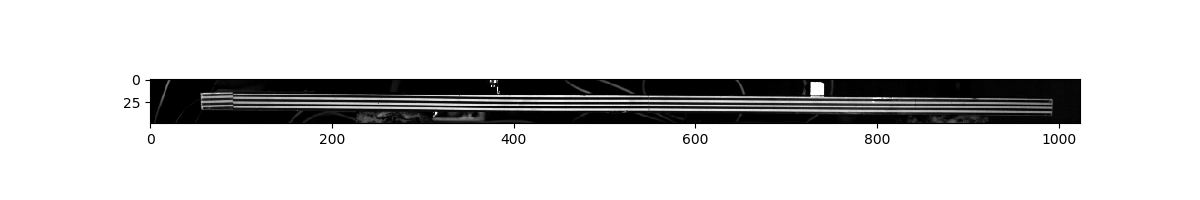

In [235]:
plt.figure(figsize=(12,2))
plt.imshow(images_[0],cmap='gray') #full image, first frame

Iskanje točk z visokim gradientom v stolpcu pod pospeškomerom:

In [236]:
number_of_points_r, points_r= get_points(images_2,area_r=(19,38),area_c=(735,736),reference=[-100,-1],direction='r',mode='points',points=7,limit=18000,mesh=False)
number_of_points_r

7

Koordinate najdenih točk:

In [237]:
points_r

array([[ 21, 735],
       [ 23, 735],
       [ 26, 735],
       [ 28, 735],
       [ 30, 735],
       [ 33, 735],
       [ 35, 735]])

Najdenen točke, prikazane na nosilcu:

<IPython.core.display.Javascript object>


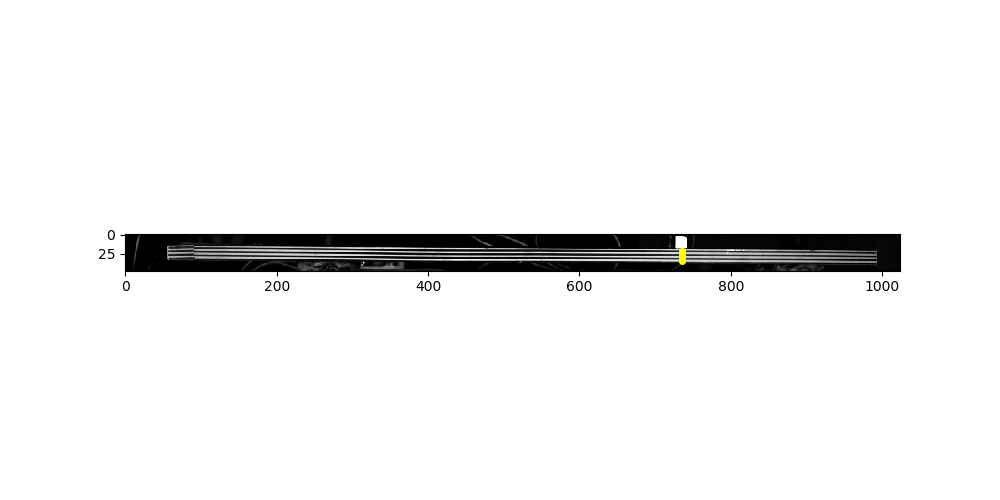

In [238]:
show_points(images_,reference=[-100,-1],points=points_r)

# Podobmočja

Podobmočje velikosti 3x3 s središčem v eni izmed najdenih točk:

<IPython.core.display.Javascript object>


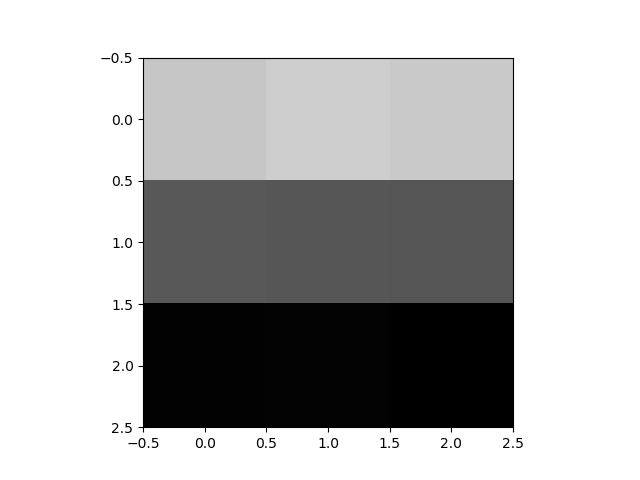

In [239]:
plt.figure()
plt.imshow(subset(images_2,points_r[0][0],points_r[0][1],3)[0],cmap='gray',vmax=2**16)

In [20]:
points_r

array([[ 21, 735],
       [ 23, 735],
       [ 26, 735],
       [ 28, 735],
       [ 30, 735],
       [ 33, 735],
       [ 35, 735]])

Nizi slik vseh podobmočij skozi posnetek:

In [240]:
subset_1 = subset(images,points_r[0][0],points_r[0][1],3)

In [241]:
subset_2 = subset(images,points_r[1][0],points_r[1][1],3)

In [242]:
subset_3 = subset(images,points_r[2][0],points_r[2][1],3)

In [243]:
subset_4 = subset(images,points_r[3][0],points_r[3][1],3)

In [244]:
subset_5 = subset(images,points_r[4][0],points_r[4][1],3)

In [245]:
subset_6 = subset(images,points_r[5][0],points_r[5][1],3)

In [246]:
subset_7 = subset(images,points_r[6][0],points_r[6][1],3)

# Določevanje pomikov

Izračunani pomiki z uporabo enega podobmočja:

In [247]:
displ_1 = displacement(subset(images,23,735,3))[0]

Izračunani pomiki z uporabo povprečja pomikov 6 podobmočij:

In [248]:
r_of_points = points_r[:,0]
displ = np.empty((len(r_of_points),len(images)))
for i in range(len(r_of_points)):
    displ_i,_,_ = displacement(subset(images,r_of_points[i],735,3))
    displ[i,:] = displ_i
displ = np.average(displ,axis=0)

Časovni niz:

In [249]:
t1 = np.linspace(0,1,len(displ))

<IPython.core.display.Javascript object>


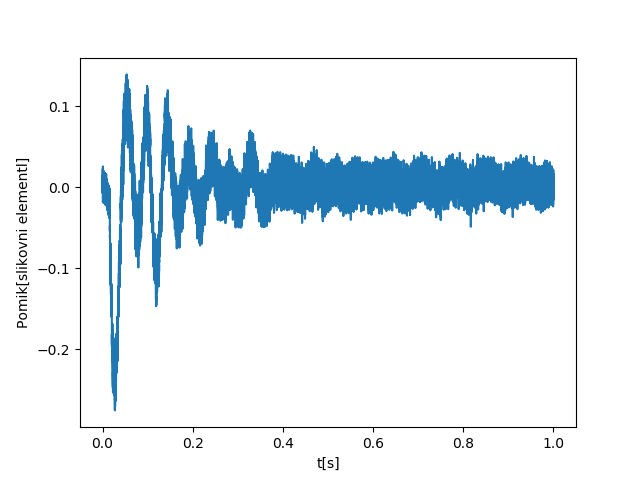

Text(0.5, 0, 't[s]')

In [257]:
plt.figure()
plt.plot(t1,displ)
plt.ylabel('Pomik[slikovni elementl]')
plt.xlabel('t[s]')

Fourierjeva transformacija nizov pomikov z uporabo 1 in 6 podobmočij:

In [258]:
F = 2.0*abs(np.fft.rfft(displ-np.average(displ)))/(len(displ))
fr = np.fft.rfftfreq(len(displ), d=1/fs)

In [259]:
F2 = 2.0*abs(np.fft.rfft(displ_1-np.average(displ_1)))/(len(displ_1))
fr2 = np.fft.rfftfreq(len(displ_1), d=1/fs)

<IPython.core.display.Javascript object>


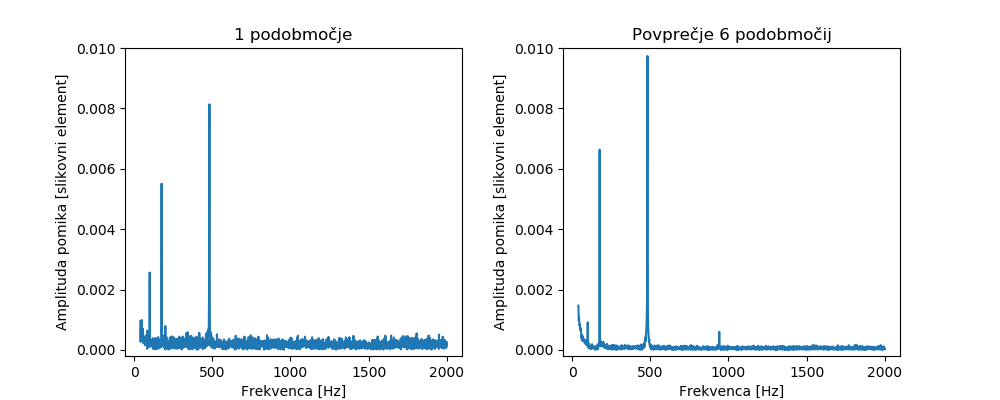

Text(0.5, 0, 'Frekvenca [Hz]')

In [260]:
fig,plot = plt.subplots(1,2,figsize=(10,4),gridspec_kw={'wspace': 0.3})
plot[0].plot(fr2[40:2000],F2[40:2000],label='1 podobmočje')
plot[0].set_title('1 podobmočje')
plot[0].set_ylim(-0.0002,0.01)
plot[1].plot(fr[40:2000],F[40:2000],label='povprečje')
plot[1].set_title('Povprečje 6 podobmočij')
plot[1].set_ylim(-0.0002,0.01)
plot[0].set_ylabel('Amplituda pomika [slikovni element]')
plot[0].set_xlabel('Frekvenca [Hz]')
plot[1].set_ylabel('Amplituda pomika [slikovni element]')
plot[1].set_xlabel('Frekvenca [Hz]')

Šum pri uporabi 1 podobmočja:

In [261]:
np.average(F2[1000:3000])

0.00018364274406928703

Šum pri uporabi povprečja 6 podobmočij:

In [262]:
np.average(F[1000:3000])

6.0336761530701556e-05

# Razmerniki dušenja

Lastne frekvence [Hz]:

In [263]:
freq = [176,482,941,1552,2305]

V prvih 750 framih oziroma 0,015s ni nihanja:

In [266]:
subset1 = subset_1[750:,:,:] #impulse at frame number 750
subset2 = subset_2[750:,:,:]
subset3 = subset_3[750:,:,:]
subset4 = subset_4[750:,:,:]
subset5 = subset_5[750:,:,:]
subset6 = subset_6[750:,:,:]
subset7 = subset_7[750:,:,:]

In [267]:
displ = displ[int(fs*0.015):] # impulse at 0.015s

## $\omega_1 = 178.4 Hz $

In [268]:
n = 20
number_of_frames1 = int(n/freq[0]*fs)
splits1 = np.arange(0,len(displ), number_of_frames1)
splits1

array([    0,  5681, 11362, 17043, 22724, 28405, 34086, 39767, 45448])

Padanje amplitude prve lastne frekvence po kratkih identifikacijah skozi posnetek:

<IPython.core.display.Javascript object>


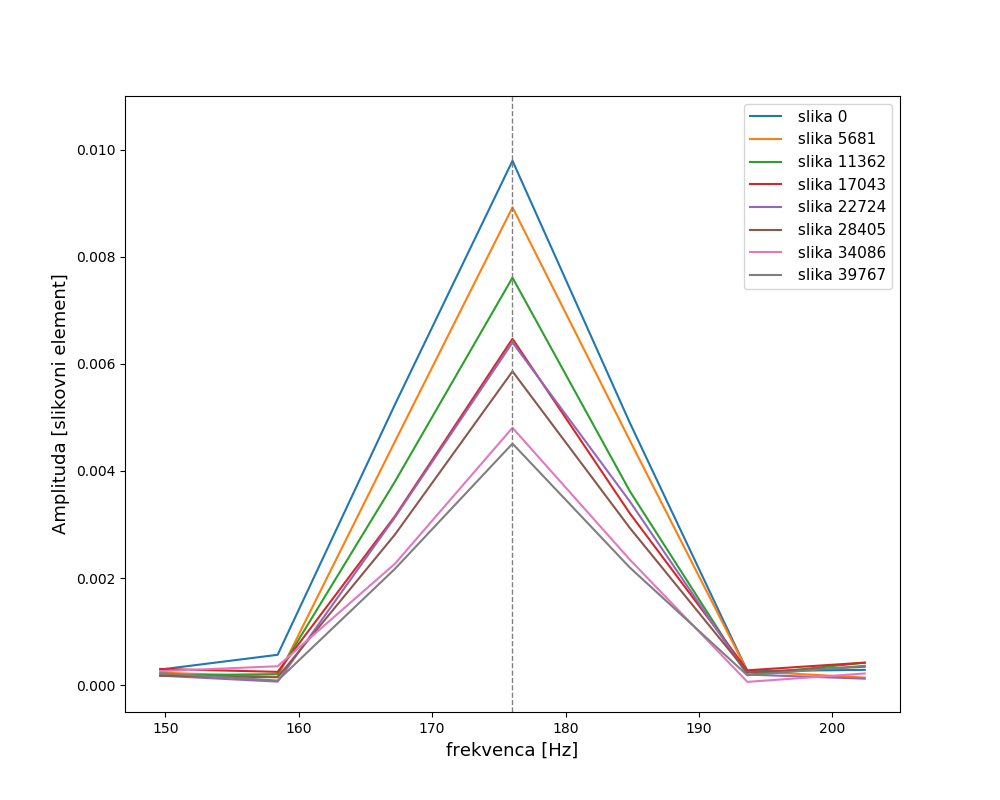

(-0.0005, 0.011)

In [270]:
plt.figure(figsize=(10,8))
for i in splits1[:-1]:
    dis_i = displ[i:i+splits1[1]]
    hann=np.hanning(len(dis_i))
    dis_i = dis_i*hann
    F_i = 2.0*abs(np.fft.rfft(dis_i-np.average(dis_i)))/(len(dis_i))*len(hann)/sum(hann)
    fr_i = np.fft.rfftfreq(len(dis_i), d=1/fs)
    sel = (fr_i> freq[0]-fr_i[3]) & (fr_i < freq[0]+fr_i[4])
    plt.plot(fr_i[sel], F_i[sel], label=(f" slika {i}"))
plt.legend(fontsize=11)
plt.ylabel('Amplituda [slikovni element]',fontsize=13)
plt.xlabel('frekvenca [Hz]',fontsize=13)
plt.axvline(x=freq[0], linestyle='--', color='gray', linewidth='1')
#plt.xticks([])
#plt.yticks([])
plt.ylim(-0.0005,0.011)

### Razmernik dušenja

Izračunan razmernik dušenja prve lastne frekvence:

<IPython.core.display.Javascript object>


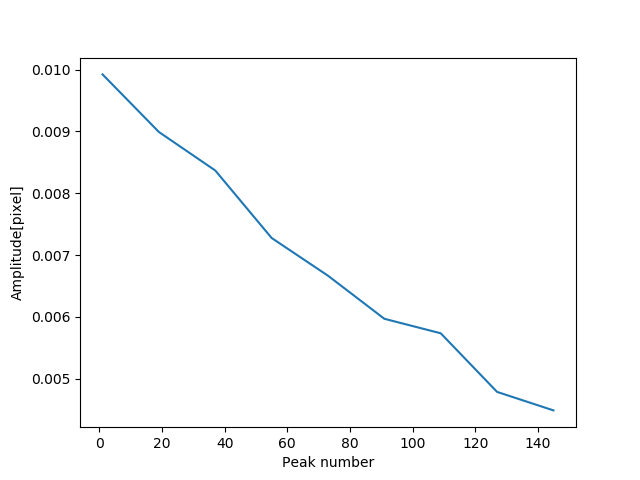

0.0008762422000232839

In [271]:
damping_ratio((subset1,subset2,subset3,subset4,subset5,subset6,subset7),176,(1,178),18)[2]

## $\omega_2 = 482.2 Hz $

In [272]:
n = 50
number_of_frames2 = int(n/freq[1]*fs)
splits2 = np.arange(0,len(displ), number_of_frames2)
splits2

array([    0,  5186, 10372, 15558, 20744, 25930, 31116, 36302, 41488,
       46674])

Padanje amplitude druge lastne frekvence po kratkih identifikacijah skozi posnetek:

<IPython.core.display.Javascript object>


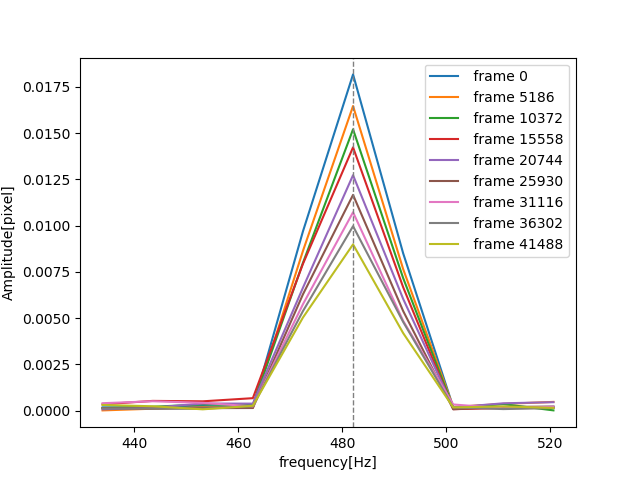

In [273]:
plt.figure()
for i in splits2[:-1]:
    dis_i = displ[i:i+splits2[1]]
    hann = np.hanning(len(dis_i))
    dis_i = dis_i*hann
    F_i = 2.0*abs(np.fft.rfft(dis_i-np.average(dis_i)))/(len(dis_i))*len(hann)/sum(hann)
    fr_i = np.fft.rfftfreq(len(dis_i), d=1/fs)
    sel = (fr_i> freq[1]-fr_i[5]) & (fr_i < freq[1]+fr_i[5])
    plt.plot(fr_i[sel],F_i[sel], label=(f" frame {i}"))
plt.legend()
plt.ylabel('Amplitude[pixel]')
plt.xlabel('frequency[Hz]')
plt.axvline(x=freq[1], linestyle='--',color='gray', linewidth='1')

### Razmernik dušenja

Izračunan razmernik dušenja druge lastne frekvence:

<IPython.core.display.Javascript object>


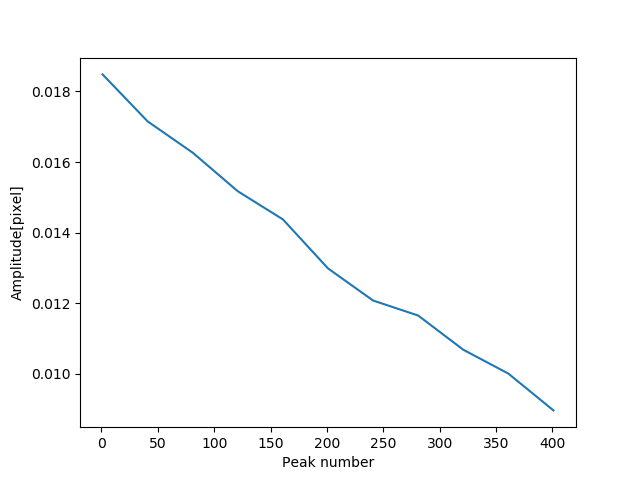

0.000287910201219819

In [274]:
damping_ratio((subset1,subset2,subset3,subset4,subset5,subset6,subset7),482,(1,480),40)[2]

## $\omega_3 = 941.2 Hz $

In [275]:
n = 100
number_of_frames3 = int(n/freq[2]*fs)
splits3 = np.arange(0, len(displ), number_of_frames3)
splits3

array([    0,  5313, 10626, 15939, 21252, 26565, 31878, 37191, 42504,
       47817])

Padanje amplitude tretje lastne frekvence po kratkih identifikacijah skozi posnetek:

<IPython.core.display.Javascript object>


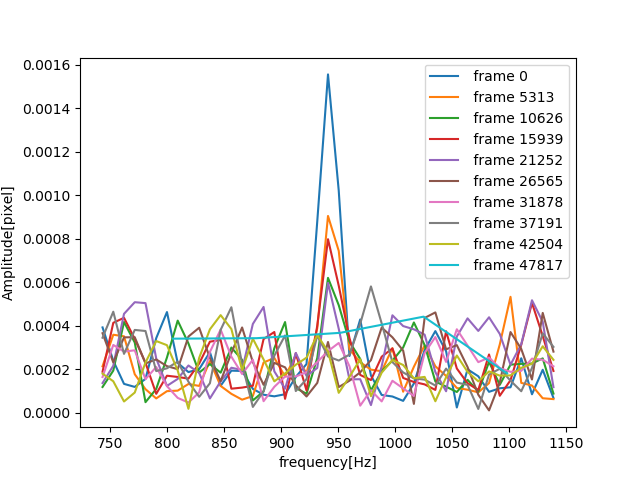

Text(0.5, 0, 'frequency[Hz]')

In [276]:
plt.figure()
for i in splits3[:20]:
    dis_i = displ[i:i+splits3[1]]
    hann= np.hanning(len(dis_i))
    dis_i = dis_i*hann
    F_i = 2.0*abs(np.fft.rfft(dis_i-np.average(dis_i)))/(len(dis_i))*len(hann)/sum(hann)
    fr_i = np.fft.rfftfreq(len(dis_i), d=1/fs)
    sel = (fr_i> freq[2]-200) & (fr_i < freq[2]+200)
    plt.plot(fr_i[sel],F_i[sel],label=(f" frame {i}"))
plt.legend()
plt.ylabel('Amplitude[pixel]')
plt.xlabel('frequency[Hz]')    

### Razmernik dušenja

Izračunan razmernik dušenja tretje lastne frekvence:

<IPython.core.display.Javascript object>


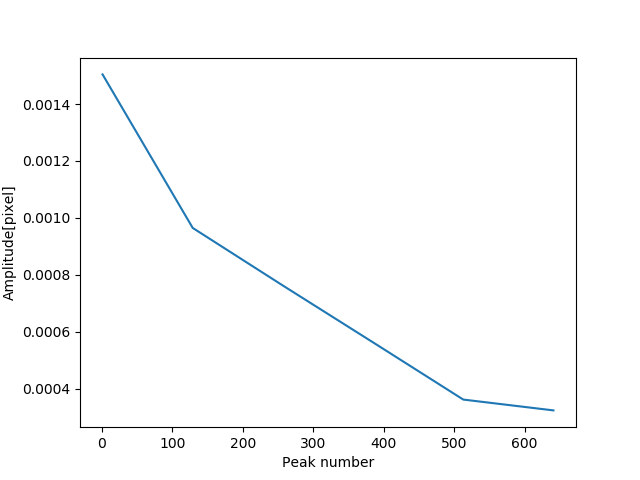

0.0003821108581642155

In [277]:
damping_ratio((subset1,subset2,subset3,subset4,subset5,subset6,subset7),941,(1,800),128)[2]

## $\omega_4 = 1549.0 Hz $

Četrte lastne frekvence s tem eksperimentom ne moremo identificirati nikjer v posnetku.

In [278]:
n = 100
number_of_frames4 = int(n/freq[3]*fs)
splits4 = np.arange(0,len(subset1),number_of_frames4)
splits4

array([    0,  3221,  6442,  9663, 12884, 16105, 19326, 22547, 25768,
       28989, 32210, 35431, 38652, 41873, 45094, 48315])

<IPython.core.display.Javascript object>


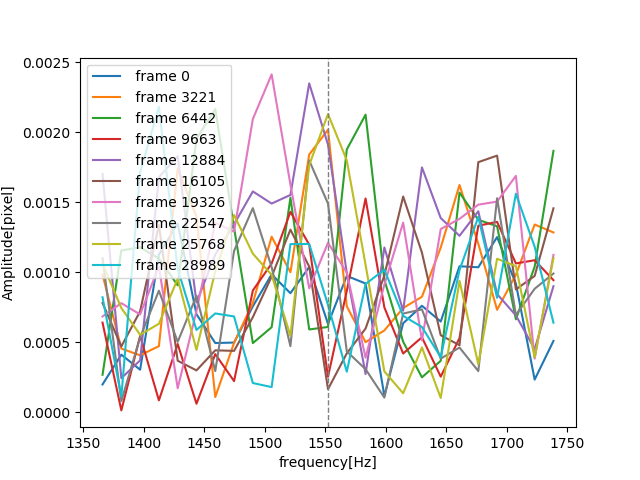

In [279]:
plt.figure()
for i in splits4[:10]:
    dis_i,_,_ = displacement(subset1[i:i+splits4[1]])
    hann = np.hanning(len(dis_i))
    dis_i = dis_i*hann
    F_i = 2.0*abs(np.fft.rfft(dis_i-np.average(dis_i)))/(len(dis_i))*len(hann)/sum(hann)
    fr_i = np.fft.rfftfreq(len(dis_i), d=1/fs)
    sel = (fr_i> freq[3]-200) & (fr_i < freq[3]+200)
    plt.plot(fr_i[sel],F_i[sel],label=(f" frame {i}"))
plt.legend()
plt.ylabel('Amplitude[pixel]')
plt.xlabel('frequency[Hz]')    
plt.axvline(x=freq[3], linestyle='--', color='gray', linewidth='1')

### Razmernik dušenja

Posledično ne moremo izračunati razmernika dušenja, saj opazujemo le amplitude naključnega šuma.

<IPython.core.display.Javascript object>


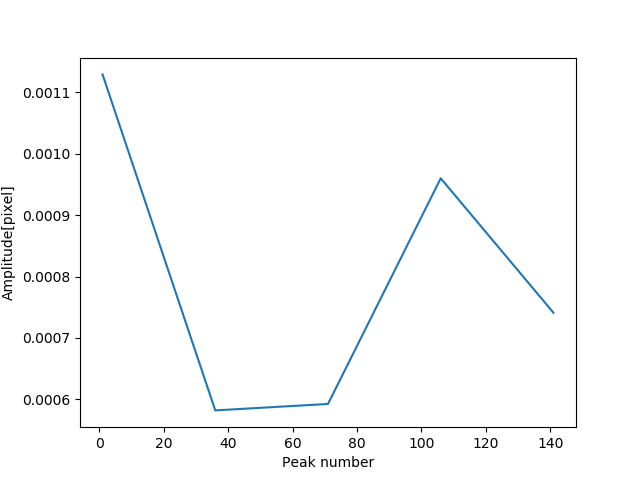

0.00047861230859918484

In [280]:
damping_ratio((subset1,subset2,subset3,subset4,subset5,subset6,subset7),1549,(1,200),35)[2]